<center><h1> Multimodal Face-Prosody Analysis Using OpenFace and Parselmouth </h1>


<h3> James Trujillo ( james.trujillo@donders.ru.nl )<br>
    Wim Pouw ( wim.pouw@donders.ru.nl )<br>
    18-11-2021 </h3>
    
<img src="./images/BOOTCAMP.png"> </center>

<h3> Info documents </h3>
This coding module gives an introduction to using the output of OpenFace together with prosodic data. We'll discuss cleaning the data, extracting relevant features, merging kinematic data with annotation data, and using Parselmouth (a python interface for working with Praat) to extract prosodic features from the audio stream. Finally, we'll perform a simple analysis of kinematic-prosodic alignment.
<br><br>

* OpenFace: https://github.com/TadasBaltrusaitis/OpenFace
* OpenFace citation: OpenFace 2.0: Facial Behavior Analysis Toolkit Tadas Baltrušaitis, Amir Zadeh, Yao Chong Lim, and Louis-Philippe Morency, IEEE International Conference on Automatic Face and Gesture Recognition, 2018

* A detailed tutorial for using ExploFace: https://github.com/emrecdem/exploface/blob/master/TUTORIALS/tutorial1.ipynb 

* location code: 
https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/MediaBodyTracking

* Packages to install: <i>praat-parselmouth, seaborn </i>

* citation: 
Trujillo, J.P. & Pouw, W.T.J.L.(2021-11-18). <i>  Multimodal Face-Prosody Analysis Using OpenFace and Parselmouth </i> \[day you visited the site]. Retrieved from: https://github.com/WimPouw/EnvisionBootcamp2021/tree/main/Python/MediaBodyTracking 


<h3> Introduction </h3>



<h2>Example Analysis Case: Eyebrows and Prosody </h2>
As a simple example of how we can utilize OpenFace for multimodal analysis, let's look at the coupling between eyebrow movement and speech prosody. Kim, Cvejic & Davis (2014) found a correlation between these two measures, but used wired trackers attached to the face, which may be less ideal for studying natural interaction.<br>
For this case example, we'll use a video from the Bielefeld Speech-and-Gesture Alignment (SaGA) corpus (Lücking et al., 2013 https://doi.org/10.1007/s12193-012-0106-8 ).
<br>
The tracking is already done, although you can download the original video file from our OSF page if you want to try running it yourself. Let's load in the data and apply some smoothing.

In [122]:
import exploface
import pandas as pd
from scipy import signal
openface_file = "./Timeseries_output/v07.csv"

openface_features = exploface.get_feature_time_series(openface_file)


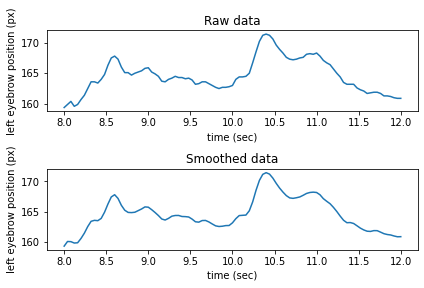

In [17]:
# let's compare raw and smoothed position
plt.subplot(2,1,1)
plt.plot(openface_features.loc[200:300,"timestamp"],openface_features.loc[200:300,"y_24"])
plt.xlabel("time (sec)")
plt.ylabel("left eyebrow position (px)")
plt.title("Raw data")
plt.subplot(2,1,2)
plt.plot(openface_features.loc[200:300,"timestamp"],signal.savgol_filter(openface_features.loc[200:300,"y_24"],5,3))
plt.xlabel("time (sec)")
plt.ylabel("left eyebrow position (px)")
plt.title("Smoothed data")
plt.tight_layout()
plt.show()

As we see above, the smoothing helps to iron our some of the jitter that is inherent to video based tracking, without affecting the main shape of the signal. <br>
Before we go on to any analysis, we need to get a time-series that is useful for us. In this case, we currently only have the position of the eyebrow landmarks in pixel space. This isn't always helpful, as movement of the head will also affect this position, and (at least for A/V coupling) we are mostly interested in kinematics, not position.<br>


In [50]:
import math
eyebrow_L = openface_features[["timestamp","x_24","y_24"]].rename({"x_24":'X',"y_24":"Y"},axis='columns')
eyebrow_R = openface_features[["timestamp","x_19","y_19"]].rename({"x_19":'X',"y_19":"Y"},axis='columns')
nose = openface_features[["timestamp","x_33","y_33"]].rename({"x_33":'X',"y_33":"Y"},axis='columns')

def calculate_velocity(ts, nose,FPS):
    '''
    We want to calculate velocity, but not of the eyebrow out of context of the face -
    rather we want to get the relative movement. To do so, we calculate it as a funcion of
    where the eyebrow is in relation to a fixed point, such as the nose
    '''
    # first, get the relative position
    # we'll use list comprehension to make a new timeseries consisting of x,y pairs 
    rel_ts = [ [row['X']-nose.loc[idx,'X'], row['Y']-nose.loc[idx,'Y']] for idx,row in ts.iterrows()]
    
    
    IDX = 0
    vel = []
    for coords in rel_ts[1:]:
        Prev_coords = rel_ts[IDX]
        # first calculate displacement
        DISPLACE = math.hypot(float(coords[0]) - float(Prev_coords[0]), float(coords[1]) - float(Prev_coords[1]))
        # remove any change in head position
        
        # then calculate velocity
        vel.append(DISPLACE * FPS)
        IDX += 1
    vel = list(vel)
    # now smooth the velocity time-series
    vel_sm = signal.savgol_filter(vel, 5,3)
    
    return vel_sm

eyebrow_L_sm = calculate_velocity(eyebrow_L, nose, 25)
eyebrow_R_sm = calculate_velocity(eyebrow_R, nose, 25)

Now that we have some time series to work with, let's get some annotations and use these to calculate the kinematic-prosodic coupling. For our prosody calculations, we'll be using a package called Parselmouth. Parselmouth provides a Python interface for PRAAT and allows us to directly calculate (and manipulae) many features of a speech signal.<br>
First, let's load in the annotations, get the speech signal, and extract the pitch values.


In [109]:
# pip install pympi-ling
import pympi
import parselmouth
from parselmouth.praat import call

annot_file = pd.read_csv("./annoations/ELAN_ppn7_SaGA_speech_sentence.csv")

timestamps = eyebrow_L["timestamp"]

annot_file.head()
# first we load in the audio file
sound = parselmouth.Sound("./audio/v07.mp3")

for annot_idx,row in annot_file.iterrows():
    # now we get the audio fragment corresponding to this annotation
    annot_start = row["Begin Time - msec"]/1000
    annot_end = row["End Time - msec"]/1000
    sound_frag = sound.extract_part(from_time=annot_start,to_time=annot_end)
    
    # we'll also get the motion tracking timestamps for this fragment
    timestamps_current = timestamps[int(annot_start*25):int(annot_end*25)]
    timestamps_current = timestamps_current.reset_index()
    
    # now extract pitch values
    pitch = call(sound_frag, "To Pitch", 0.01, 75, 300)
    pitch_times = pitch.xs()
    pitch_time_s = list(pitch_times)
    pitch_time_s = [val + (annot_start) for val in pitch_time_s]
    pitch_values = pitch.selected_array['frequency']
    pitch_values = list(pitch_values)
    
    # now we want to get the maximum value and its time point
    max_pitch = max(pitch_values)
    pitch_index = pitch_values.index(max_pitch)
    
    # we should also get the max eyebrow movement and its index
    # first we need to take a subset of the data, which corresponds to our annotation
    # Since we know the data start at 0, we can convert the annotation times (currently in seconds)
    # into frame numbers
    annot_start_index = int(annot_start*25)
    annot_end_index = int(annot_end*25)
    
    eyebrow_L_this_annot = list(eyebrow_L_sm[annot_start_index:annot_end_index])
    eyebrow_R_this_annot = list(eyebrow_R_sm[annot_start_index:annot_end_index])
    # now we get the max value and index
    max_brow_L = max(eyebrow_L_this_annot)
    max_brow_R = max(eyebrow_R_this_annot)
    max_brow_L_index = eyebrow_L_this_annot.index(max_brow_L)
    max_brow_R_index = eyebrow_R_this_annot.index(max_brow_R)
    
    # now let's update our annotation dataframe to have all of these values
    annot_file.loc[annot_idx,"pitch_peak_val"] = max_pitch
    annot_file.loc[annot_idx,"pitch_peak_time"] = pitch_time_s[pitch_index]
    annot_file.loc[annot_idx,"brow_L_val"] = max_brow_L
    annot_file.loc[annot_idx,"brow_R_val"] = max_brow_R
    annot_file.loc[annot_idx,"brow_L_time"] = timestamps_current.loc[max_brow_L_index,"timestamp"]
    annot_file.loc[annot_idx,"brow_R_time"] = timestamps_current.loc[max_brow_R_index,"timestamp"]



To get a correspondence between the two signals, we need to calculate the offset between them. The code below calculates the time difference between the peak eyebrow movement and the peak pitch. The hypothesis then, is that the peaks of the respective signals should align with one another in an utterance. 

In [110]:
annot_file["pitch_browL_diff"] = annot_file["brow_L_time"] - annot_file["pitch_peak_time"]
annot_file["pitch_browR_diff"] = annot_file["brow_R_time"] - annot_file["pitch_peak_time"]

Now we can draw the distributions and see if there is any correspondence/alignment. Note that we could also save this dataframe as a new .csv file and continue analyses in R, but for now let's see what we can do in Python.<br>
For plotting, we'll use the seaborn package. 

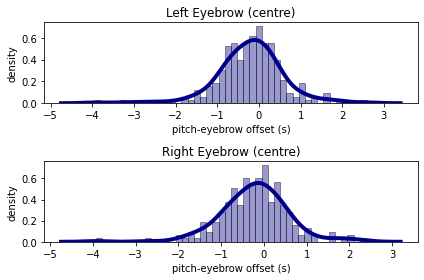

Mean offset of left eyebrow: -0.2033018965161955 seconds
Mean offset of right eyebrow: -0.21075644197074297 seconds


In [119]:
import seaborn as sns
import numpy as np

plt.subplot(2,1,1)
sns.distplot(annot_file['pitch_browL_diff'], hist=True, kde=True, 
             bins=int(len(annot_file)/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel("pitch-eyebrow offset (s)")
plt.ylabel("density")
plt.title("Left Eyebrow (centre)")
plt.tight_layout()
plt.subplot(2,1,2)
sns.distplot(annot_file['pitch_browR_diff'], hist=True, kde=True, 
             bins=int(len(annot_file)/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel("pitch-eyebrow offset (s)")
plt.ylabel("density")
plt.title("Right Eyebrow (centre)")
plt.tight_layout()
plt.show()
print("Mean offset of left eyebrow: " + str(np.mean(annot_file["pitch_browL_diff"])) + " seconds")
print("Mean offset of right eyebrow: " + str(np.mean(annot_file["pitch_browR_diff"])) + " seconds")


We can see that for both eyebrows, the kinematic peak occurs approximately 200 ms before the pitch peak. 

<b>Bonus: Extracting audio</b>
Don't have a separate audio file?  You can easily extract the audio from video using moviepy's ffmpeg. Below see an example of how this would be done, assuming you have a directory called <i>video</i> containing the original video file.

In [63]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip, ffmpeg_extract_audio

ffmpeg_extract_audio("./video/V07_original.mp4","./audio/v07.mp3")

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful
